# Analysis of Perp Futures Funding Rates 

In [1]:
#
# Daily to Yearly Interest Calculation
#
r = .01  #8-hour interest rate %
r = (r / 100)  

import math
apr = math.pow(r+1, 365*3) - 1
print("APR corresponding to a 8-hour rate of %.4f%% is %.4f%%" % (r * 100, apr * 100))

In [2]:
#Need to restart kernel for notebook plotting preferences to be implemented
import pandas as pd
import numpy as np
import datetime

#Use this for inline
%matplotlib inline
#%matplotlib qt
#%matplotlib notebook

#Use this for popout images
#matplotlib tk  

import matplotlib.pyplot as plt

In [3]:
import sys
import utils.fetchBars_sql as fetchBars

## Read-in Bitmex Data

Read, from a local SQL db, one minute bar data and funding rate data for XBTUSD.

In [4]:
#XBTUSD price data
df_perp_bars = fetchBars.readBarsDB_pd('XBTUSD', 'bitmex')


In [5]:
df_perp_bars.tail(3)

,O,H,L,C,V
ts,,,,,
2020-06-08 01:55:00+00:00,9762.0,9762.5,9755.0,9755.5,1793260.0
2020-06-08 01:56:00+00:00,9755.5,9755.5,9755.0,9755.0,296142.0
2020-06-08 01:57:00+00:00,9755.0,9759.0,9755.5,9759.0,213403.0


In [6]:
#XBTUSD funding info
df_F = fetchBars.fetchFundingData('XBTUSD', 'bitmex', startTS = datetime.datetime(2018,1,1))
df_F['fund_rate'] = df_F['fund_rate'] * 100

In [7]:
df_F.tail(3)

,fund_rate
ts,
2020-06-07 08:00:00+00:00,0.01
2020-06-07 16:00:00+00:00,0.01
2020-06-08 00:00:00+00:00,0.01


## Analysis/Visualization of Funding Rate and Price - Bitmex

In [8]:
df_F['F_sum'] = df_F['fund_rate'].cumsum()
df_F['zero'] = 0

#add close XBTUSD price bars to df_F
df_F['xbtusd_price'] = df_perp_bars['C']
df_F = df_F.dropna()
df_F.tail(5)


,fund_rate,F_sum,zero,xbtusd_price
ts,,,,
2020-06-06 16:00:00+00:00,0.01,-1.632,0,9647.0
2020-06-07 00:00:00+00:00,0.01,-1.622,0,9668.5
2020-06-07 08:00:00+00:00,0.01,-1.612,0,9659.5
2020-06-07 16:00:00+00:00,0.01,-1.602,0,9488.5
2020-06-08 00:00:00+00:00,0.01,-1.592,0,9760.5


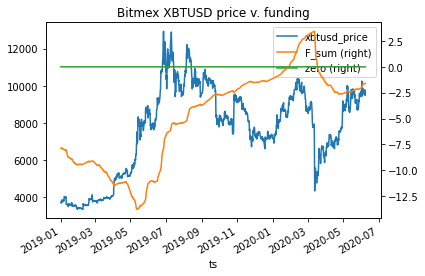

In [9]:
df_F.loc[:, ['xbtusd_price', 'F_sum', 'zero']].plot(secondary_y = ['F_sum', 'zero'], title = 'Bitmex XBTUSD price v. funding')

## Analysis/Visualization of Funding Rate and Price - Binance

In [10]:
#
# Set binance_symbols to the symbols that you want to fetch from the db. Possible symbols include:
# ['BTCUSDT', 'ETHUSDT', 'BCHUSDT', 'XRPUSDT', 'EOSUSDT', 'LTCUSDT', 'QTUMUSDT', 
#  'ATOMUSDT', 'IOTAUSDT', 'ADAUSDT', 'XTZUSDT', 'BNBUSDT', 'IOSTUSDT', 'ETCUSDT', 
#  'XMRUSDT', 'ZECUSDT', 'ONTUSDT', 'BATUSDT', 'VETUSDT', 'TRXUSDT', 'XLMUSDT']
#

binance_symbols = ['BTCUSDT', 'ETHUSDT', 'BCHUSDT', 'XRPUSDT', 'EOSUSDT', 'LTCUSDT']


In [11]:
#
# Read-in perp future price and funding rates for binance products
#

binance_data = {}
for s in binance_symbols:
    print("Reading data for", s, " ...")
    d = fetchBars.readBarsDB(s, "binance") #Returns dictof (ts, o, h, l, c, v) tuples, indexed by ts
    bars_dict = {pd.Timestamp(ts, unit = "s"): {'ts': pd.Timestamp(ts, unit = "s"), 'c':c} for ts, o, h, l, c, v in d.values()}

    #Funding Rates
    _df_F = fetchBars.fetchFundingData(s, 'binance', startTS = datetime.datetime(2018,1,1))
    _df_F = _df_F.loc[~_df_F.index.duplicated(keep='first')]
    values = []
    for ts, f_rate in zip(_df_F.index, _df_F['fund_rate'].values):
        if ts.tz_convert(None) in bars_dict:
            o = bars_dict[ts.tz_convert(None)]
            o.update({'fund_rate': f_rate})
            values.append(o)

    df = pd.DataFrame(values)
    df = df.set_index('ts')
    df = df.dropna()
    df = df.sort_index()     
    
    binance_data[s] = df
    

Reading data for BTCUSDT  ...
Reading data for ETHUSDT  ...
Reading data for BCHUSDT  ...
Reading data for XRPUSDT  ...
Reading data for EOSUSDT  ...
Reading data for LTCUSDT  ...


#### Plot of Binance Cumulative Funding Rate v. Product Price

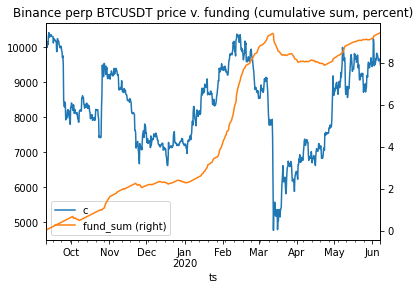

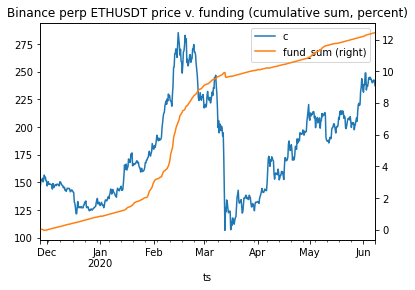

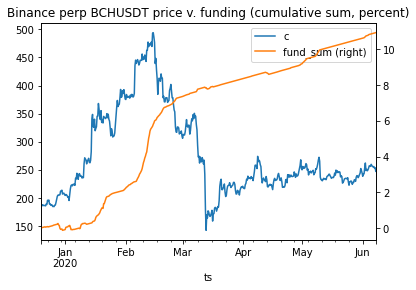

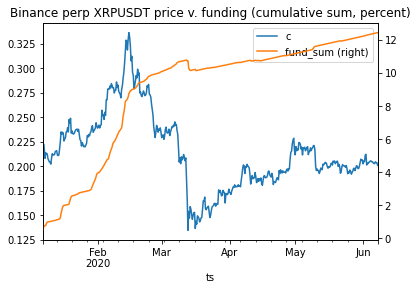

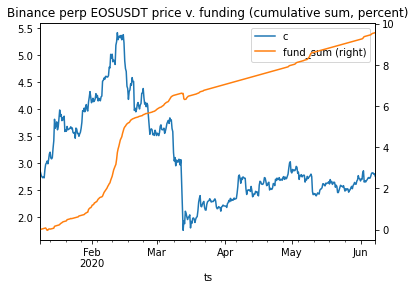

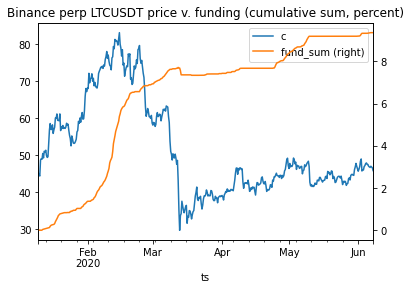

In [12]:
#plot
for s, df in binance_data.items():
    df['fund_sum'] = df['fund_rate']*100
    df['fund_sum'] = df['fund_sum'].cumsum()

    title = 'Binance perp ' + s + ' price v. funding (cumulative sum, percent)'
    df.loc[:, ['c', 'fund_sum']].plot(secondary_y = ['fund_sum'], title = title)

#### Plot of Funding Rates over Time

In [13]:
SYMBOL = 'ETHUSDT'

df = binance_data[SYMBOL]
df['fund_rate'] = df['fund_rate'] * 100 # convert to percent
df['zero'] = 0


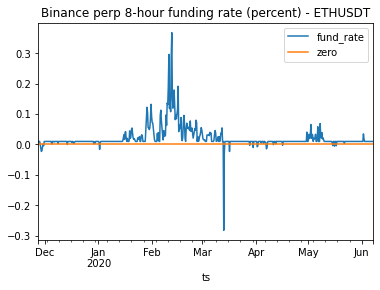

In [14]:
#
# line graph of funding rate over time
#
title = "Binance perp 8-hour funding rate (percent) - " + SYMBOL
df.loc[:, ['fund_rate', 'zero']].plot(title = title)